<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project2/blob/master/model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 2

### Iglezou Myrto - 111520170038

# Model 2

In [1]:
import pandas as pd 
from pandas import DataFrame, read_csv

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv")
df = pd.DataFrame(data=twitterData)
df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [3]:
df['target'].replace({4: 1}, inplace = True)
X = df['text']
y = df['target']

## Data pre-processing

### Removing the scpecial characters

In [4]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [5]:
X = X.apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [6]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

X = X.apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
X = X.apply(lambda x: x.lower())

### Removing the upercase

In [8]:
X = X.apply(lambda x: x.lower())

## Vectorizing

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [10]:
def vectorizeData(X_train,X_test,X_val,vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_val = vectorizer.transform(X_val)
    
    return X_train,X_test,X_val

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3,   random_state = 4, stratify = y)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

split_int = int(len(train_X)*0.8)

train_X, val_X = train_X[:split_int], train_X[split_int:]
train_y, val_y = train_y[:split_int], train_y[split_int:]

tv = TfidfVectorizer(max_features=500)
X_train, X_test, X_val =  vectorizeData(train_X, test_X, val_X, tv)

X_train = X_train.toarray()
y_train = train_y.values

X_val = X_val.toarray()
y_val = val_y.values

X_test = X_test.toarray()
y_test = test_y.values


## Batching sentences together with a DataLoader

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# bach size
batch_size = 100

# dataloader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

## Architecture of NN

In [14]:
class Model_2(nn.Module):
    def __init__(self,input_size,num_classes = 1,hidden_size1 = 500,hidden_size2 = 100):
        super(Model_2, self).__init__()
     
        self.fc1 = nn.Linear(input_size,hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [15]:
def train(model,X,y,optimizer,loss_fn):

    # step 1. Zero the gradients
#         model.zero_grad()
        optimizer.zero_grad()
    # step 2. Compute the output
        y_pred = model(X)
    # step 3. Compute the loss
        loss = loss_fn(y_pred.squeeze(), y)
    # step 4. use loss to produce gradients
        loss.backward()
    # step 5. use optimizer to take gradient step
        optimizer.step()
    
        return loss.item()

In [16]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)
  loss = loss_fn(y_pred.squeeze(), y)

  return loss.item()


In [17]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)

## Training



In [18]:
net = Model_2(len(X_train[0]))
learning_rate = 0.0001
loss_fn=nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [19]:
num_epochs = 5

list_of_losses = []
valid_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    net.train()
    for batch_index, batch in (enumerate(train_loader)):
        x_train, y_train = batch[0], batch[1]
        x_train = x_train.float()
        y_train = y_train.float()
        
        loss_t = train(net,x_train,y_train,optimizer,loss_fn)       
        running_loss += (loss_t - running_loss) / (batch_index + 1)
               
    list_of_losses.append(running_loss)

    running_loss = 0.0
    net.train()
    for batch_index, batch in (enumerate(valid_loader)):
        x_train, y_train = batch[0], batch[1]
        x_train = x_train.float()
        y_train = y_train.float()
        
        loss_t = validate(net,x_train,y_train,loss_fn)       
        running_loss += (loss_t - running_loss) / (batch_index + 1)
    valid_losses.append(running_loss)
       

## Check for Overfitting-Underfitting

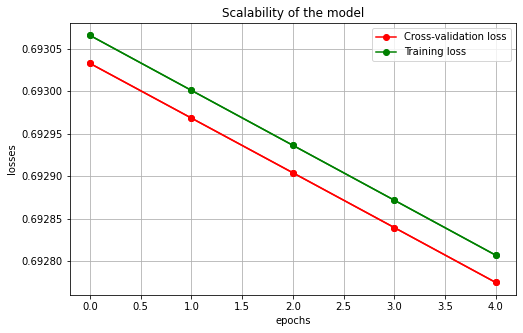

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(valid_losses,'o-',color="r")

plt.plot(list_of_losses,'o-',color="g")

plt.grid()

plt.plot(valid_losses, 'o-', color="r",
                label="Cross-validation loss")
plt.plot(list_of_losses,  'o-', color="g",
                label="Training loss")

plt.legend(loc="best")

plt.xlabel("epochs")
plt.ylabel("losses")
plt.title("Scalability of the model")

plt.show()

## Testing

In [21]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

accuracy = []
f1 = []
recall = []
precision = []

for bidx, batch in (enumerate(test_loader)):
    x_test, y_test = batch[0], batch[1]
    x_test = x_test.float()
    y_test = y_test.float()
    y_test = y_test.numpy()
    y_pred = predict(net,x_test)
    y_pred = y_pred.detach().numpy()
    
    acc = accuracy_score(y_test, y_pred)
    f1_sc = f1_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    
    accuracy.append(acc)
    f1.append(f1_sc)
    recall.append(rec)
    precision.append(prec)
    

## Scores

In [22]:
print("Accuracy: ",np.mean(accuracy))
print("F1-score: ",np.mean(f1))
print("Recall-score: ",np.mean(recall))
print("Precision: ",np.mean(precision))

Accuracy:  0.5360572916666667
F1-score:  0.5306657062566025
Recall-score:  0.5361028395824773
Precision:  0.5370581822946102
